## Project: Data Representation and Clustering
#### Gaurav Singh

- Representing data into more interpretable formats.
- Well defined clustering so that data points are classified as per meaningful clusters and it's evaluation using the labels
- Transfer learning and image classification

## Part 1: Clustering on Text Data

In [10]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import contractions
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import NMF
from sklearn import datasets, metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

import pickle
import umap

import itertools
import matplotlib.colors as colors

from matplot import plot_mat
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix

from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score


from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

import hdbscan


In [11]:
# Fetching all data from 20newgroups
newsgroups_data = datasets.fetch_20newsgroups(subset='all', remove=('headers', 'footers'))

In [12]:
# One time imports
stopWords = set(stopwords.words('english'))

In [13]:
def getScores(true, predicted):
    scores = {}
    scores["Homogeneity"] = homogeneity_score(true, predicted)
    scores["Completeness"] = completeness_score(true, predicted)
    scores["V-measure"] = v_measure_score(true, predicted)
    scores["Adjusted Rand Index"] = adjusted_rand_score(true, predicted)
    scores["Adjusted mutual information score"] = adjusted_mutual_info_score(true, predicted)
    
    return scores


In [14]:
# Raw data dimensions and visualizations
print("Number of classes in newgroups data: {}".format(len(newsgroups_data.target_names)))
print("Number of datapoints in newsgroups data: {}".format(len(newsgroups_data.data)))
print("First newarticle:\n", newsgroups_data.data[0])

Number of classes in newgroups data: 20
Number of datapoints in newsgroups data: 18846
First newarticle:
 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [15]:
#  Function to clean the raw HTML text

"""
- HTML artifacts removal
- Links removal
- quotes removal
- Special characters removal
- Extra spaces removal
- Changing the short forms to full forms using contractions
- Punctuations removal
- Changing all text to lower case
"""

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r'http\S+', '', text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = texter.strip()
    texter = contractions.fix(texter)
    texter = re.sub('''[!"#$%&'()*+,/;:-<=>?@[\]^_`{|}~-]''', '', texter)
    texter = texter.lower()
    texter = re.sub(' +', ' ', texter)
    if texter == "":
        texter = ""
    return texter

def removeStopwords(words, stopWords):
    return " ".join([word for word in words if word not in stopWords])

def preprocess(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [removeStopwords(nltk.word_tokenize(sentence), stopWords) for sentence in sample]
    sample = '.'.join(sample)
    return sample

In [247]:
def getSVD(n_comp, data):
    SVD = TruncatedSVD(n_components=n_comp, random_state=42)
    SVD.fit(data)
    return SVD

# NMF Non-negative Matrix Factorization
def getNMF(n_comp, data):
    NMFmodel = NMF(n_components=n_comp, init='random', max_iter=300, random_state=42)
    NMFmodel.fit(data)
    return NMFmodel

def getLabels(true, predicted):
    size = len(true)
    incorrect = np.count_nonzero(true - predicted)
    
    if incorrect > (size/2):
        return 1 - predicted
    return predicted

In [17]:
data = newsgroups_data.data
labelNames = np.array(newsgroups_data.target_names)
labels = np.array(newsgroups_data.target)
stringLabels = np.array([labelNames[label] for label in labels])

In [18]:
# Constructing subset of data

class_1 = ['comp.graphics',  'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class_2 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']


subsetData = []
subsetLabels = []
subsettrueLabels = []

for idx, label in enumerate(stringLabels):
    if label in class_1:
        subsetData.append(data[idx])
        subsetLabels.append(0)
        subsettrueLabels.append(label)
    
    elif label in class_2:
        subsetData.append(data[idx])
        subsetLabels.append(1)
        subsettrueLabels.append(label)

In [19]:
# Feature Extraction using CountVectorizer and TF-IDF transformation using Pipeline.
featurePipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(subsetData)

In [20]:
features = featurePipeline.transform(subsetData)

In [21]:
print("Dimensions of TF-IDF matrix: {}".format(features.shape))

Dimensions of TF-IDF matrix: (7882, 21132)


## Question 1

Dimensions of TF-IDF matrix of two classes as given : (7882, 21132)

In [22]:
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=3000, n_init=50).fit(features)
predictedLabels = kmeans.labels_

In [23]:
Cmatrix = contingency_matrix(subsetLabels, 1 - predictedLabels)
predictedLabels = getLabels(subsetLabels, predictedLabels) # because the classes were interchanged by cluster labels.

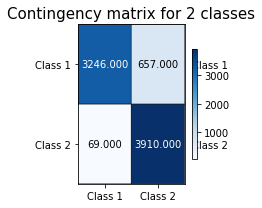

In [24]:
plot_mat(Cmatrix, size=(3,3), title="Contingency matrix for 2 classes", xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'])


### Question 2

The contingency matrix is plotted above.

No the contingency matrix is not always square. Example when the number of clusters formed are more than the no. of true classes.

Contingency matrix is square when its about classification problems and is referred as confusion matrix.

In [25]:
# Scores for two class clustering
scores = getScores(subsetLabels, predictedLabels)
scores

{'Homogeneity': 0.5942490015150945,
 'Completeness': 0.6052721260505387,
 'V-measure': 0.5997099147063929,
 'Adjusted Rand Index': 0.6654594117635557,
 'Adjusted mutual information score': 0.5996729309950798}

### Question 3

5 measures for K-means clustering:

'Homogeneity': 0.5942490015150945, </br>
'Completeness': 0.6052721260505387, <br>
'V-measure': 0.5997099147063929, <br>
'Adjusted Rand Index': 0.6654594117635557, <br>
'Adjusted mutual information score': 0.5996729309950798

### Dense representations for better k- means clustering

### Question 4

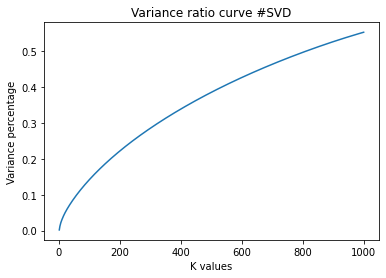

In [26]:
# Plotting variance graph from 1000 top components from SVD decomposition

n_components = 1000
SVD = getSVD(n_components, features)
varianceRatios = SVD.explained_variance_ratio_
cumulativeVarianceRatios = np.cumsum(varianceRatios)


plt.plot(np.arange(1000) + 1, cumulativeVarianceRatios)
plt.xlabel("K values")
plt.ylabel("Variance percentage")
plt.title("Variance ratio curve #SVD")
plt.show()

### Question 5

In [27]:
# For SVD decompositions

r = [1,2,3,5,10,20,50,100,300]

SVDScores_homogeneity = []
SVDScores_completeness = []
SVDScores_v_measure = []
SVDScores_adj_rand_idx = []
SVDScores_adj_mutual_inf_score = []


for k in r:
    SVD = getSVD(k, features)
    transformed = SVD.transform(features)
    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=3000, n_init=50).fit(transformed)
    predictedLabels = kmeans.labels_
    predictedLabels = getLabels(subsetLabels, predictedLabels)
    scores = getScores(subsetLabels, predictedLabels)
    SVDScores_homogeneity.append(scores['Homogeneity'])
    SVDScores_completeness.append(scores['Completeness'])
    SVDScores_v_measure.append(scores['V-measure'])
    SVDScores_adj_rand_idx.append(scores['Adjusted Rand Index'])
    SVDScores_adj_mutual_inf_score.append(scores['Adjusted mutual information score'])


In [28]:
# For NMF

NMFScores_homogeneity = []
NMFScores_completeness = []
NMFScores_v_measure = []
NMFScores_adj_rand_idx = []
NMFScores_adj_mutual_inf_score = []

for k in r:
    NMFmodel = getNMF(k, features)
    transformed = NMFmodel.transform(features)
    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=3000, n_init=50).fit(transformed)
    predictedLabels = kmeans.labels_
    predictedLabels = getLabels(subsetLabels, predictedLabels)
    scores = getScores(subsetLabels, predictedLabels)
    NMFScores_homogeneity.append(scores['Homogeneity'])
    NMFScores_completeness.append(scores['Completeness'])
    NMFScores_v_measure.append(scores['V-measure'])
    NMFScores_adj_rand_idx.append(scores['Adjusted Rand Index'])
    NMFScores_adj_mutual_inf_score.append(scores['Adjusted mutual information score'])


/Users/gauravsingh/miniforge3/envs/py38_torch/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/gauravsingh/miniforge3/envs/py38_torch/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/gauravsingh/miniforge3/envs/py38_torch/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/gauravsingh/miniforge3/envs/py38_torch/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


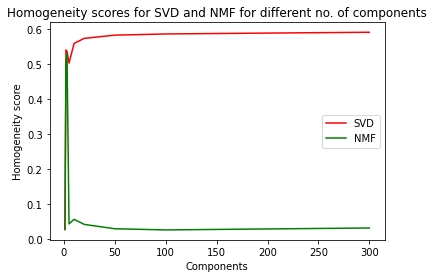

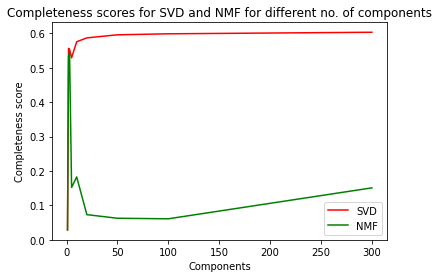

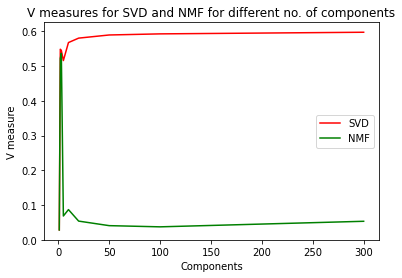

In [29]:
plt.plot(r, SVDScores_homogeneity, color='r', label='SVD')
plt.plot(r, NMFScores_homogeneity, color='g', label='NMF')
  
plt.xlabel("Components")
plt.ylabel("Homogeneity score")
plt.title("Homogeneity scores for SVD and NMF for different no. of components")
  
plt.legend()
plt.show()


plt.plot(r, SVDScores_completeness, color='r', label='SVD')
plt.plot(r, NMFScores_completeness, color='g', label='NMF')
plt.xlabel("Components")
plt.ylabel("Completeness score")
plt.title("Completeness scores for SVD and NMF for different no. of components")
  
plt.legend()
plt.show()

plt.plot(r, SVDScores_v_measure, color='r', label='SVD')
plt.plot(r, NMFScores_v_measure, color='g', label='NMF')
plt.xlabel("Components")
plt.ylabel("V measure")
plt.title("V measures for SVD and NMF for different no. of components")
  
plt.legend()
plt.show()

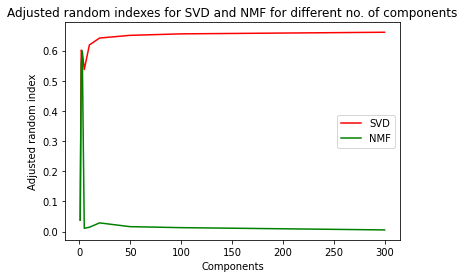

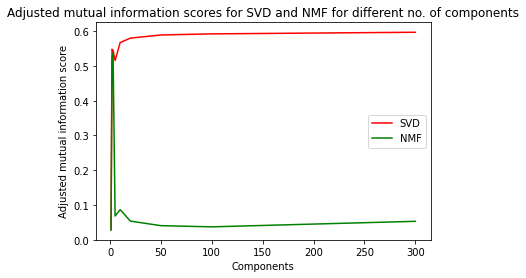

In [30]:
plt.plot(r, SVDScores_adj_rand_idx, color='r', label='SVD')
plt.plot(r, NMFScores_adj_rand_idx, color='g', label='NMF')
  
plt.xlabel("Components")
plt.ylabel("Adjusted random index")
plt.title("Adjusted random indexes for SVD and NMF for different no. of components")
  
plt.legend()
plt.show()



plt.plot(r, SVDScores_adj_mutual_inf_score, color='r', label='SVD')
plt.plot(r, NMFScores_adj_mutual_inf_score, color='g', label='NMF')
  
plt.xlabel("Components")
plt.ylabel("Adjusted mutual information score")
plt.title("Adjusted mutual information scores for SVD and NMF for different no. of components")
  
plt.legend()
plt.show()

##### Answer 5

The best choice of r for NMF seems to be around 3-4 components. </br>
For the SVD the best choice of r is around the same 3-4 components if we see the first peak.</br>
After that the results fro SVD are increasing slowly. But since there is a tradeoff between higher dimensionality and the performance of K-means the first peak results are more meaningful hence chosing r = 2

### Question 6

As r increases, the number of components increases. There is a tradeoff between the number of dimensions and the segregating power of K-means clustering. As the number of components were very low, the discriminative power of the algorithm was low since there is not much information in those components. The at certain number the information held by those components and the discriminative power of the K-means in the feature space attains its maxima. Then the algorithm starts to perform worse in not able to discriminate the distances between different clusters.

And thus the non monotonic behaviour is justified.

### Question 7

On seeing the metrics of question 3 and to that of metrics with reduced dimesions, on average the reduced dimensions metrics with SVD are performing slightly better than that of full features with less time taken for clustering and delivering better results.

### Visualising the clusters

In [31]:
# Visualisation using NMF reduction

# chosen r = 3
NMF_r = 3

NMFmodel = getNMF(NMF_r, features)

transformed = NMFmodel.transform(features)

kmeans = KMeans(n_clusters=2, random_state=0, max_iter=3000, n_init=50).fit(transformed)
predictedLabelsNMF = kmeans.labels_

# Projecting 3 dimensional features onto 2D plane using NMF

SVDmodel = getSVD(2, transformed)
twoDimNMF = SVDmodel.transform(transformed)

In [32]:
# Visualisation using SVD reduction

# chosen r = 2
SVD_r = 2

SVDmodel = getSVD(SVD_r, features)

twoDimSVD = SVDmodel.transform(features)

kmeans = KMeans(n_clusters=2, random_state=0, max_iter=3000, n_init=50).fit(transformed)
predictedLabelsSVD = kmeans.labels_

In [33]:
def plotScatter(data, labels):
    labels = np.array(labels)
    data = np.array(data)
    data1 = data[np.where(labels == 1)]
    data0 = data[np.where(labels == 0)]
    
    plt.scatter(data1[:,0] , data1[:,1] , color = 'red')
    plt.scatter(data0[:,0] , data0[:,1] , color = 'black')
    plt.show()

### Question 8

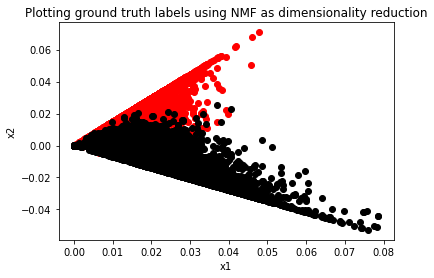

In [34]:
# Plotting scatter plots with ground truth labels and using NMF for dimensionality reduction.
plt.title("Plotting ground truth labels using NMF as dimensionality reduction")
plt.xlabel("x1")
plt.ylabel("x2")
plotScatter(twoDimNMF, subsetLabels)

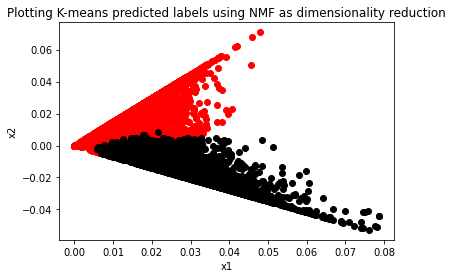

In [35]:
plt.title("Plotting K-means predicted labels using NMF as dimensionality reduction")
plt.xlabel("x1")
plt.ylabel("x2")
plotScatter(twoDimNMF, 1 - predictedLabelsNMF)

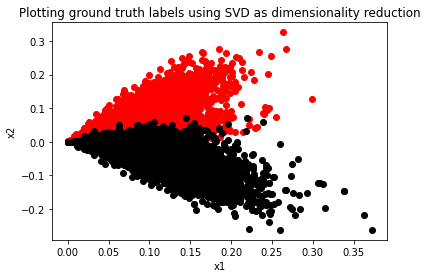

In [36]:
plt.title("Plotting ground truth labels using SVD as dimensionality reduction")
plt.xlabel("x1")
plt.ylabel("x2")
plotScatter(twoDimSVD, subsetLabels)

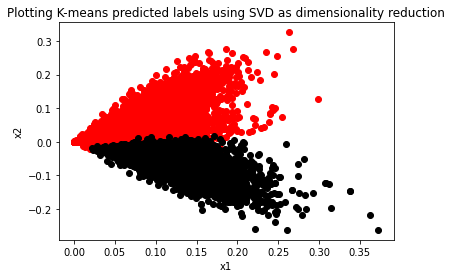

In [37]:
plt.title("Plotting K-means predicted labels using SVD as dimensionality reduction")
plt.xlabel("x1")
plt.ylabel("x2")
plotScatter(twoDimSVD, 1 - predictedLabelsSVD)

The dimensionality of the data was reduced by SVD and NMF as explained in question 5. And it was further reduced to two dimensions so as to visualise it via scatter plot.

I observe a clear boundary between the two clusters. Though they are not separated by a margin in this 2-D plot. 
I see a lot of commonality between the ground truth labels plot and the cluster assignments of the K-means clustering and there is a minute difference in the way the boundary separates the points. 

One thing to notice is that the dimensionality reduction did help to visualise it but I am seeing a few outliers on the scatter plot which could have been mapped nearby to the riginal clusters. 

The distribution is not very ideal for K-means clustering. Since its like wedge shaped and not like real ball shaped distribution which is very ideal for K-means algroithm to shine.

## Working with full 20 classes

In [38]:
#  Creating the features using TF-IDF transformation

fullPipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(data)

fullFeatures = fullPipeline.transform(data)

In [39]:
print("Dimensions of TF-IDF matrix: {}".format(fullFeatures.shape))

Dimensions of TF-IDF matrix: (18846, 43038)


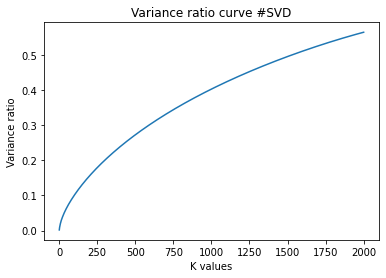

In [40]:
# Dimensionality reduction of full data

# Choosing SVD as it performs well generally and is much faster.

# Choosing upper bound of n_components such that it works well with K means as well. > 1000 
# is really absurd for Kmeans.

n_components = 2000
SVD = getSVD(n_components, fullFeatures)
varianceRatios = SVD.explained_variance_ratio_
cumulativeVarianceRatios = np.cumsum(varianceRatios)


plt.plot(np.arange(n_components) + 1, cumulativeVarianceRatios)
plt.xlabel("K values")
plt.ylabel("Variance ratio")
plt.title("Variance ratio curve #SVD")
plt.show()

In [41]:
r = [1,2,3,5,10,20,50,100,300, 500, 1000]

SVDScores_homogeneity = []
SVDScores_completeness = []
SVDScores_v_measure = []
SVDScores_adj_rand_idx = []
SVDScores_adj_mutual_inf_score = []


for k in r:
    SVD = getSVD(k, fullFeatures)
    transformed = SVD.transform(fullFeatures)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=3000, n_init=50).fit(transformed)
    predictedLabels = kmeans.labels_
#     predictedLabels = getLabels(subsetLabels, predictedLabels)
    scores = getScores(labels, predictedLabels)
    SVDScores_homogeneity.append(scores['Homogeneity'])
    SVDScores_completeness.append(scores['Completeness'])
    SVDScores_v_measure.append(scores['V-measure'])
    SVDScores_adj_rand_idx.append(scores['Adjusted Rand Index'])
    SVDScores_adj_mutual_inf_score.append(scores['Adjusted mutual information score'])

### Question 10

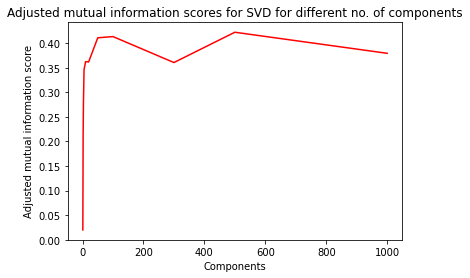

In [42]:
plt.plot(r, SVDScores_adj_mutual_inf_score, color='r')
  
plt.xlabel("Components")
plt.ylabel("Adjusted mutual information score")
plt.title("Adjusted mutual information scores for SVD for different no. of components")
  
plt.show()

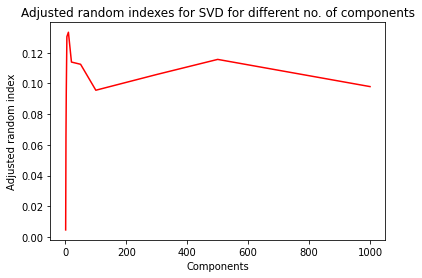

In [43]:
plt.plot(r, SVDScores_adj_rand_idx, color='r')
  
plt.xlabel("Components")
plt.ylabel("Adjusted random index")
plt.title("Adjusted random indexes for SVD for different no. of components")
  
plt.show()

In [44]:
# Choosing n components to be 50.

best_r = 50

SVD = getSVD(best_r, fullFeatures)
transformed = SVD.transform(fullFeatures)

kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(transformed)
predictedLabels = kmeans.labels_

scores = getScores(labels, predictedLabels)

#### Answer 10:

The cluster scores are low for K-means run on dimensionality reduction done with SVD as shown below.
There is a trend all the cluster scores are first increasing and then decreasing. Choosing the optimal components value for SVD is between 50 - 100 since most of the scores achieve their best value in that range.
Adjusted random index takes its best value when n components = 10 but the value is very low compared to other scores.

Choosing K = 20,
Dimensionality reduction method = SVD.
No. of components chosen: 50.

The 5 clustering metrics and the contingency matrix (20 X 20) are given below:

In [45]:
# Clustering scores
scores

{'Homogeneity': 0.37586200944874926,
 'Completeness': 0.45857601184540586,
 'V-measure': 0.4131194813723549,
 'Adjusted Rand Index': 0.11244938656096547,
 'Adjusted mutual information score': 0.41102834776024916}

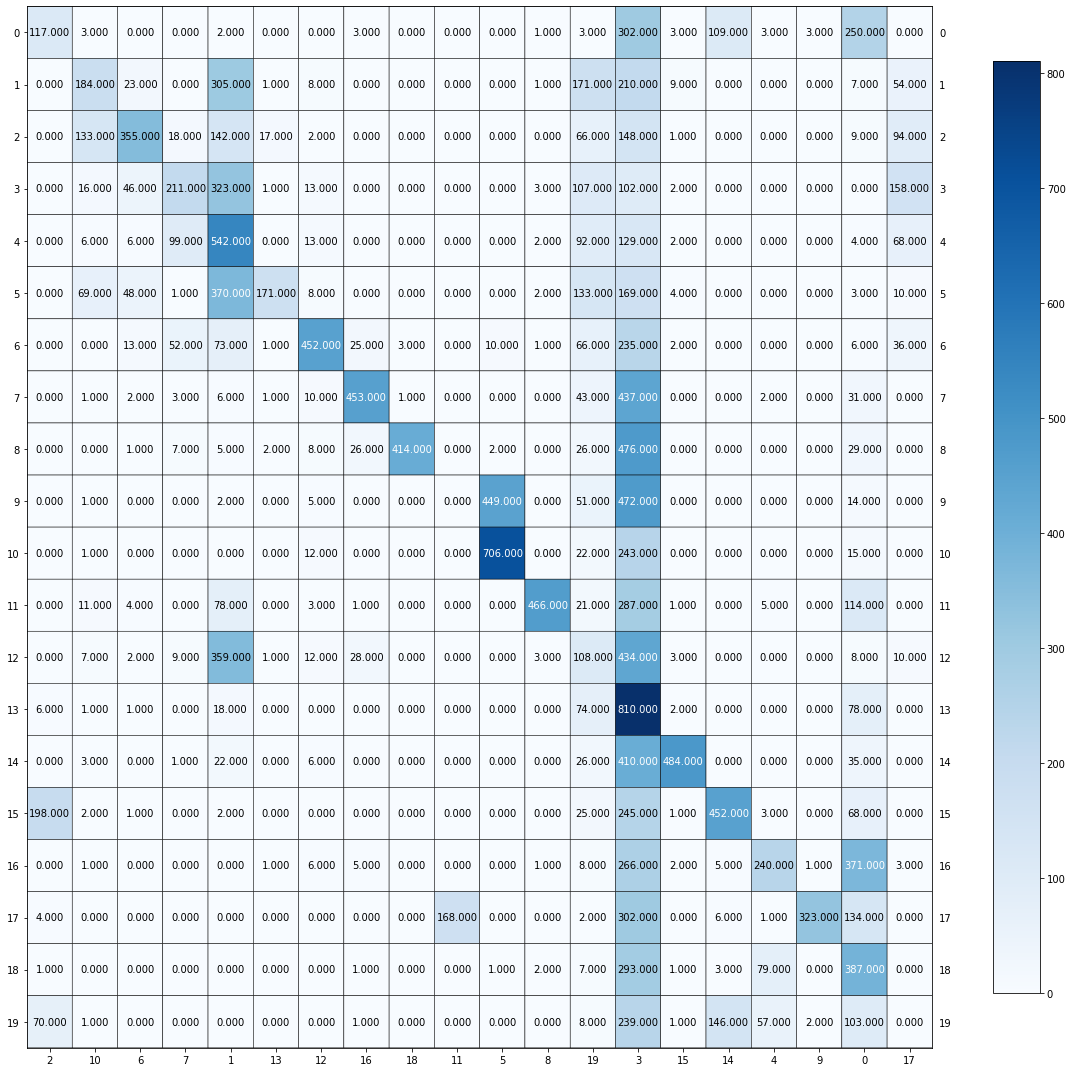

In [46]:
# Visualising contingency matrix
cm = confusion_matrix(labels, predictedLabels)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

### UMAP

#### Question 11

In [47]:
# Dimensionality reduction using UMAP

umap_fit = umap.UMAP(n_components=20)
umap_features = umap_fit.fit_transform(fullFeatures)

In [48]:
# Kmeans clustering with UMAP 20 components.
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(umap_features)
predictedLabels = kmeans.labels_

scores = getScores(labels, predictedLabels)

In [49]:
scores

{'Homogeneity': 0.011915303439345229,
 'Completeness': 0.01282021964030221,
 'V-measure': 0.012351208962218677,
 'Adjusted Rand Index': 0.002696882412425153,
 'Adjusted mutual information score': 0.009065734404541063}

In [50]:
n_comp = [5, 10, 20, 30, 40, 50, 75, 100, 200]

UMAPScores_homogeneity = []
UMAPScores_completeness = []
UMAPScores_v_measure = []
UMAPScores_adj_rand_idx = []
UMAPScores_adj_mutual_inf_score = []


for k in n_comp:
    umap_fit = umap.UMAP(n_components=k)
    umap_features = umap_fit.fit_transform(fullFeatures)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(umap_features)
    predictedLabels = kmeans.labels_
    scores = getScores(labels, predictedLabels)
    UMAPScores_homogeneity.append(scores['Homogeneity'])
    UMAPScores_completeness.append(scores['Completeness'])
    UMAPScores_v_measure.append(scores['V-measure'])
    UMAPScores_adj_rand_idx.append(scores['Adjusted Rand Index'])
    UMAPScores_adj_mutual_inf_score.append(scores['Adjusted mutual information score'])

In [51]:
UMAPScores_adj_rand_idx

[0.0016911562672956544,
 0.00209463040786006,
 0.0025241673639614308,
 0.002609746146537501,
 0.0024236433206437243,
 0.002972661683736763,
 0.00295061622086766,
 0.0024132056171847533,
 0.0026458874519850774]

The best Adjusted Rand index value for UMAP based Kmeans clustering happens at n_components = 100. Hence choosing it

In [52]:
# Setting metric with best n_components

best_umap_components = 100

umap_fit = umap.UMAP(n_components=best_umap_components, random_state=0, metric='euclidean')
umap_features = umap_fit.fit_transform(fullFeatures)

kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(umap_features)
predictedLabels = kmeans.labels_

scoresEucUMAP = getScores(labels, predictedLabels)

In [53]:
scoresEucUMAP

{'Homogeneity': 0.004903617340411761,
 'Completeness': 0.0051039669481124,
 'V-measure': 0.005001786667008602,
 'Adjusted Rand Index': 0.00053799139140666,
 'Adjusted mutual information score': 0.0017245171021564687}

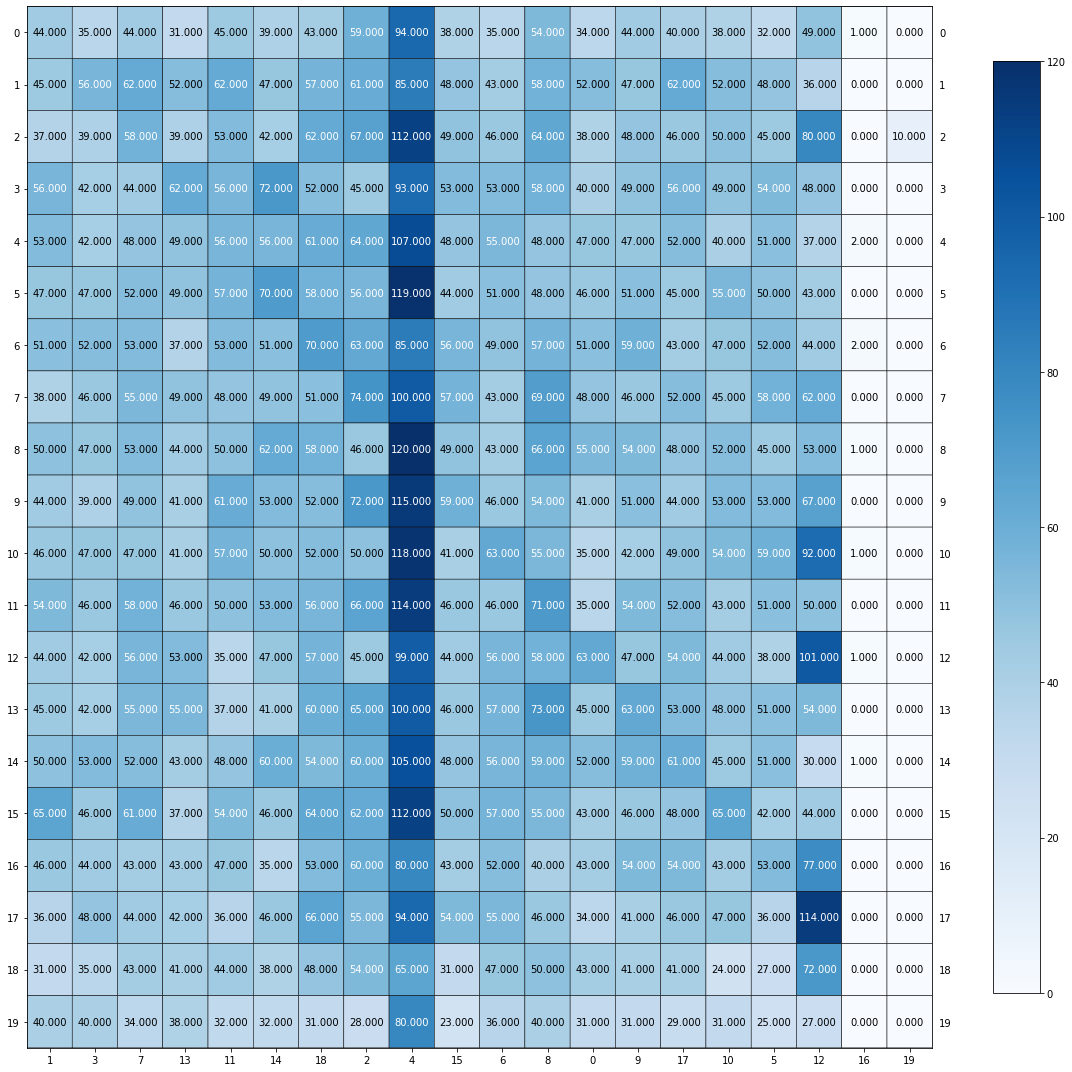

In [54]:
cmEUC = confusion_matrix(labels, predictedLabels)
rows, cols = linear_sum_assignment(cmEUC, maximize=True)
plot_mat(cmEUC[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

In [83]:
best_umap_components = 100

umap_fit = umap.UMAP(n_components=best_umap_components, random_state=0, metric='cosine')
umap_features = umap_fit.fit_transform(fullFeatures)

kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(umap_features)
predictedLabels = kmeans.labels_

scoresCosUMAP = getScores(labels, predictedLabels)

In [84]:
scoresCosUMAP

{'Homogeneity': 0.5707173806276715,
 'Completeness': 0.6067497438785596,
 'V-measure': 0.588182238494506,
 'Adjusted Rand Index': 0.43891485058403334,
 'Adjusted mutual information score': 0.586797994256375}

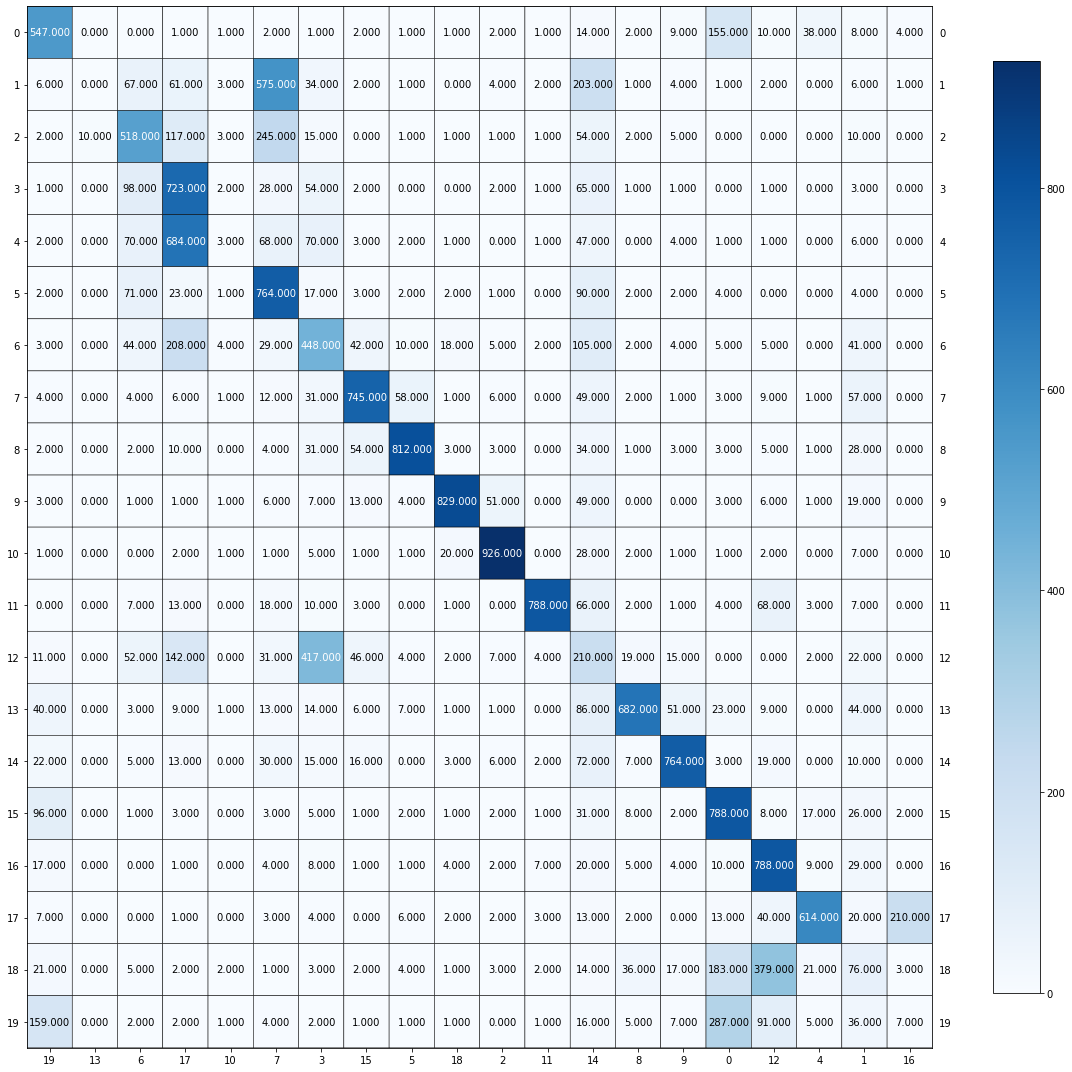

In [85]:
cmCos = confusion_matrix(labels, predictedLabels)
rows, cols = linear_sum_assignment(cmCos, maximize=True)
plot_mat(cmCos[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

### Answer 11

A linear search was done to find the number of components which perform best with K-means clustering in the range of:

[5, 10, 20, 30, 40, 50, 75, 100, 200].

Comparing the clustering scores it was found that n = 100 UMAP components is performing much better copared to others with K-means clustering. The Adjusted rand index scores for the search are given below:

[0.0016911562672956544,
 0.00209463040786006,
 0.0025241673639614308,
 0.002609746146537501,
 0.0024236433206437243,
 0.002972661683736763,
 0.0024132056171847533,
 0.00295061622086766,
 0.0026458874519850774]
 

Then with these 100 components, two UMAP metrics of distance were compared: 'eculidean' and 'cosine'

For "Euclidean" metric the clustering scores obtained with K-means were very low and the contingency matrix for the same is all radomly scattered in different clusters as shown above in the plot:

'Homogeneity': 0.004903617340411761, <br>
'Completeness': 0.0051039669481124,<br>
'V-measure': 0.005001786667008602,<br>
'Adjusted Rand Index': 0.00053799139140666,<br>
'Adjusted mutual information score': 0.0017245171021564687


For "Cosine" metric the clustering scores obtained with K-means were quite better with high clustering scores as shown below. The clustering assignment as shown above via the contingency matrix is good as well, with clear highly distinguishable allocations of data into clusters:

'Homogeneity': 0.5707173806276715, <br>
'Completeness': 0.6067497438785596,<br>
'V-measure': 0.588182238494506,<br>
'Adjusted Rand Index': 0.43891485058403334,<br>
'Adjusted mutual information score': 0.586797994256375


### Answer 12

Analysing the contingency matrces above, I see that the Euclidean matrix did not do well with the clustering. The clusters formed are quite random and not much clearly distinguishable, it looks like more of a random cluster assignment. 

For the cosine matrix, the clusters seems to are well formed with clear segregations and allocations. There seems to have some proper assigment based on underlying distance metric. There are a few points which are not able to be allocated well to a cluster and there are some clusters which have very low assignments which shows the outliers for Kmeans have to be managed well.

### Answer 13

Based on the scores and contingency matrices shown in previous questions,:

UMAP with 100 components, metric = 'cosine' seems to perform much better with K-MEANS on the 20 newsgroup data.

The Adjusted Rand Index is as high as 0.43, with V-measure as 0.58 which is way higher than the SVD or NMF scores which ranged between (0.13, 0.21) and (0.41, 0.3) respectively.

The contingency matrices for the same shows the same that UMAP + Kmeans is better. Each cluster is having way more correct dense allocations of data points for UMAP then SVD or NMF with comparatively low wrong cluster allocations.

### Agglomerative Clustering

#### Question 14

In [86]:
# Ward Agglomerative Clustering

n_components = [5, 20, 50, 100, 200]
clusters = 20
AggScores_homogeneity = []
AggScores_completeness = []
AggPScores_v_measure = []
AggScores_adj_rand_idx = []
AggScores_adj_mutual_inf_score = []


for comp in n_components:
    umap_fit = umap.UMAP(n_components=comp, metric='cosine')
    umap_features = umap_fit.fit_transform(fullFeatures)
    AggClustering = AgglomerativeClustering(n_clusters=clusters, linkage='ward').fit(umap_features)
    
    predictedLabels = AggClustering.labels_
    scores = getScores(labels, predictedLabels)
    
    AggScores_homogeneity.append(scores['Homogeneity'])
    AggScores_completeness.append(scores['Completeness'])
    AggPScores_v_measure.append(scores['V-measure'])
    AggScores_adj_rand_idx.append(scores['Adjusted Rand Index'])
    AggScores_adj_mutual_inf_score.append(scores['Adjusted mutual information score'])

In [92]:
AggScores_adj_rand_idx

[0.41217492442078074,
 0.41850328546214566,
 0.42512625114117725,
 0.4160045459802611,
 0.4173238010950882]

In [105]:
aggScores = np.vstack([AggScores_homogeneity, AggScores_completeness, AggPScores_v_measure, AggScores_adj_rand_idx, AggScores_adj_mutual_inf_score])
aggScores = aggScores.T

print("Scores for Agglomerative Clustering for ward linkage")
pd.DataFrame(aggScores, columns=['Homogeneity', 'Completeness', 'Vmeasure', 'ARI', 'AMIS'])


Scores for Agglomerative Clustering for ward linkage


,Homogeneity,Completeness,Vmeasure,ARI,AMIS
0,0.556167,0.594698,0.574788,0.412175,0.573355
1,0.557389,0.591978,0.574163,0.418503,0.572733
2,0.560388,0.594437,0.576911,0.425126,0.575490
3,0.552100,0.583679,0.567451,0.416005,0.566005
4,0.559102,0.593432,0.575755,0.417324,0.574331


In [106]:
# Choosing best n_components = 100 as its giving lowest Adjusted rand index.

best_Ward_comp = 50
clusters = 20

umap_fit = umap.UMAP(n_components=best_Ward_comp, metric='cosine')
umap_features = umap_fit.fit_transform(fullFeatures)
AggClustering = AgglomerativeClustering(n_clusters=clusters, linkage='ward').fit(umap_features)

predictedLabels = AggClustering.labels_
scores = getScores(labels, predictedLabels)

scores

{'Homogeneity': 0.5532128999826028,
 'Completeness': 0.5868772124352711,
 'V-measure': 0.569548040262317,
 'Adjusted Rand Index': 0.4030347023439802,
 'Adjusted mutual information score': 0.5681037770844866}

In [107]:
n_components = [5, 20, 50, 100, 200]
clusters = 20
AggScoresSingle_homogeneity = []
AggScoresSingle_completeness = []
AggPScoresSingle_v_measure = []
AggScoresSingle_adj_rand_idx = []
AggScoresSingle_adj_mutual_inf_score = []


for comp in n_components:
    umap_fit = umap.UMAP(n_components=comp, metric='cosine')
    umap_features = umap_fit.fit_transform(fullFeatures)
    AggClustering = AgglomerativeClustering(n_clusters=clusters, linkage='single').fit(umap_features)
    
    predictedLabels = AggClustering.labels_
    scores = getScores(labels, predictedLabels)
    
    AggScoresSingle_homogeneity.append(scores['Homogeneity'])
    AggScoresSingle_completeness.append(scores['Completeness'])
    AggPScoresSingle_v_measure.append(scores['V-measure'])
    AggScoresSingle_adj_rand_idx.append(scores['Adjusted Rand Index'])
    AggScoresSingle_adj_mutual_inf_score.append(scores['Adjusted mutual information score'])

In [108]:
aggSingleScores = np.vstack([AggScoresSingle_homogeneity, AggScoresSingle_completeness, AggPScoresSingle_v_measure
                             , AggScoresSingle_adj_rand_idx, AggScoresSingle_adj_mutual_inf_score])
aggSingleScores = aggSingleScores.T

print("Scores for Agglomerative Clustering for Single linkage")
pd.DataFrame(aggSingleScores, columns=['Homogeneity', 'Completeness', 'Vmeasure', 'ARI', 'AMIS'])

Scores for Agglomerative Clustering for Single linkage


,Homogeneity,Completeness,Vmeasure,ARI,AMIS
0,0.108424,0.695943,0.187619,0.020581,0.183878
1,0.095910,0.750839,0.170093,0.020068,0.166618
2,0.097546,0.718864,0.171782,0.019985,0.168048
3,0.006954,0.266164,0.013553,0.000083,0.009270
4,0.098007,0.714442,0.172368,0.020217,0.168451


In [229]:
# Choosing n_components to be 5 based on above adjusted rank index. All of them are very poor scores.

best_Single_comp = 5
clusters = 20

umap_fit = umap.UMAP(n_components=best_Single_comp, metric='cosine')
umap_features = umap_fit.fit_transform(fullFeatures)
AggClustering = AgglomerativeClustering(n_clusters=clusters, linkage='single').fit(umap_features)

predictedLabels = AggClustering.labels_
scores = getScores(labels, predictedLabels)

scores

### Answer 14

For UMAP the number of components were searched which worked best with each type (ward, single) of linkage criteria for Agglomerative Clustering.

The range in which the components were searched for : [5, 20, 50, 100, 200]

The data frames holding 5 clustering metrics corresponding to each type of linkage are given above.


Best For Ward linkage: 

n_components = 50<br>
n_clusters = 20<br>
metric = 'cosine'

Scores for Ward:

'Homogeneity': 0.5532128999826028, <br>
'Completeness': 0.5868772124352711, <br>
'V-measure': 0.569548040262317, <br>
'Adjusted Rand Index': 0.4030347023439802, <br>
'Adjusted mutual information score': 0.5681037770844866

Best For Single linkage:

n_components = 5<br>
n_clusters = 20<br>
metric = 'cosine'

'Homogeneity': 0.108424, <br>
'Completeness': 0.695943, <br>
'V-measure': 0.187619, <br>
'Adjusted Rand Index': 0.020581, <br>
'Adjusted mutual information score': 0.183878


Ward linkage is performing much much better.


In [110]:
# Creating a dict of UMAP features with different n_components

def getUMAP(n_components, data):
    umap_fit = umap.UMAP(n_components=n_components, metric='cosine')
    umap_features = umap_fit.fit_transform(data)
    return umap_features

UMAPDict = {}
components = [5, 20, 200]
for comp in components:
    UMAPDict[comp] = getUMAP(comp, fullFeatures)

In [115]:
SVDDict = {}
NMFDict = {}
components = [5, 20, 200]
for comp in components:
    svd = getSVD(comp, fullFeatures)
    SVDDict[comp] = svd.transform(fullFeatures)
    nf = getNMF(comp, fullFeatures)
    NMFDict[comp] = nf.transform(fullFeatures)

### DBSCAN and HDBSCAN

In [126]:
n_components = [5, 20, 200]
cluster_size = [100, 200]
metric_types = [ 'euclidean', 'manhattan', 'cosine']
minsamples = [10, 20, 50, 100]
eps_vals = [0.5, 0.8, 5]

bestDBSCAN = []
bestHDBSCAN = []

bestavgDBScore = -1000
bestavgHDBScore = -1000

bestDBScores = {}
bestHDBScores = {}

bestDBLabels = []
bestHDBLabels = []

for comp in n_components:
    xdata = UMAPDict[comp]
    
    for ep in eps_vals:
        for samples in minsamples:
            for met in metric_types:
                for cluster in cluster_size:
                    DBS = DBSCAN(min_samples=samples, metric=met, eps=ep)
                    DBS.fit(xdata)
                    DBScore = getScores(labels, DBS.labels_)
                    
                    HDB = hdbscan.HDBSCAN(min_cluster_size=cluster, min_samples=samples, cluster_selection_epsilon=ep)
                    HDB.fit(xdata)
                    HDBScore = getScores(labels, HDB.labels_)
                    
                    avgDBScore = (DBScore["Homogeneity"] + DBScore["Completeness"] + DBScore["V-measure"] + DBScore["Adjusted Rand Index"] + DBScore["Adjusted mutual information score"]) / 5 
                    avgHDBScore = (HDBScore["Homogeneity"] + HDBScore["Completeness"] + HDBScore["V-measure"] + HDBScore["Adjusted Rand Index"] + HDBScore["Adjusted mutual information score"]) / 5 
                    
                    if avgDBScore > bestavgDBScore:
                        bestavgDBScore = avgDBScore
                        bestDBSCAN = DBS
                        bestDBScores = DBScore
                        bestDBLabels = DBS.labels_
                        
                    if avgHDBScore > bestavgHDBScore:
                        bestavgHDBScore = avgHDBScore
                        bestHDBSCAN = HDB
                        bestHDBScores = HDBScore
                        bestHDBLabels = HDB.labels_
                        

In [127]:
bestDBScores

{'Homogeneity': 0.5235148929796238,
 'Completeness': 0.5426392854617677,
 'V-measure': 0.5329055650663066,
 'Adjusted Rand Index': 0.31171940870320614,
 'Adjusted mutual information score': 0.5237556916329063}

In [128]:
bestHDBScores

{'Homogeneity': 0.37458825185751765,
 'Completeness': 0.6692492369359203,
 'V-measure': 0.48032937006425697,
 'Adjusted Rand Index': 0.19408884553341005,
 'Adjusted mutual information score': 0.47953777524015656}

In [201]:
print(bestDBSCAN)
print(bestHDBSCAN)

DBSCAN(eps=0.8, metric='manhattan', min_samples=100)
HDBSCAN(cluster_selection_epsilon=0.5, min_cluster_size=100, min_samples=100)


### Question 15

For DBSCAN with UMAP hyperparameter search grid is as follows:

n_components = [5, 20, 200] <br>
metric = [ 'euclidean', 'manhattan', 'cosine'] <br>
min_samples = [10, 20, 50, 100] <br>
eps valuess = [0.5, 0.8, 5]

The best DBSCAN hyperparameters are :

eps = 0.8,<br>
metric = 'manhattan'<br>
min_samples = 100<br>
DBSCAN(eps=0.8, metric='manhattan', min_samples=100)<br>
UMAP Components = 5

Scores:

'Homogeneity': 0.5235148929796238, <br>
'Completeness': 0.5426392854617677,<br>
'V-measure': 0.5329055650663066,<br>
'Adjusted Rand Index': 0.31171940870320614,<br>
'Adjusted mutual information score': 0.5237556916329063



For HDBSCAN with UMAP hyperparameter search grid is as follows:

n_components = [5, 20, 200] <br>
min_samples = [10, 20, 50, 100] <br>
cluster_size = [100, 200]<br>
cluster_selection_epsilon = [0.5, 0.8, 5]

The best HDBSCAN hyperparameters are :

eps = 0.5,<br>
min_samples = 100<br>
min_cluster_size = 100<br>
UMAP Components = 5

'Homogeneity': 0.37458825185751765,<br>
'Completeness': 0.6692492369359203,<br>
'V-measure': 0.48032937006425697,<br>
'Adjusted Rand Index': 0.19408884553341005,<br>
'Adjusted mutual information score': 0.47953777524015656

DBSCAN seems to perform better

### Question 16

### Contingency matrix for best DBSCAN 

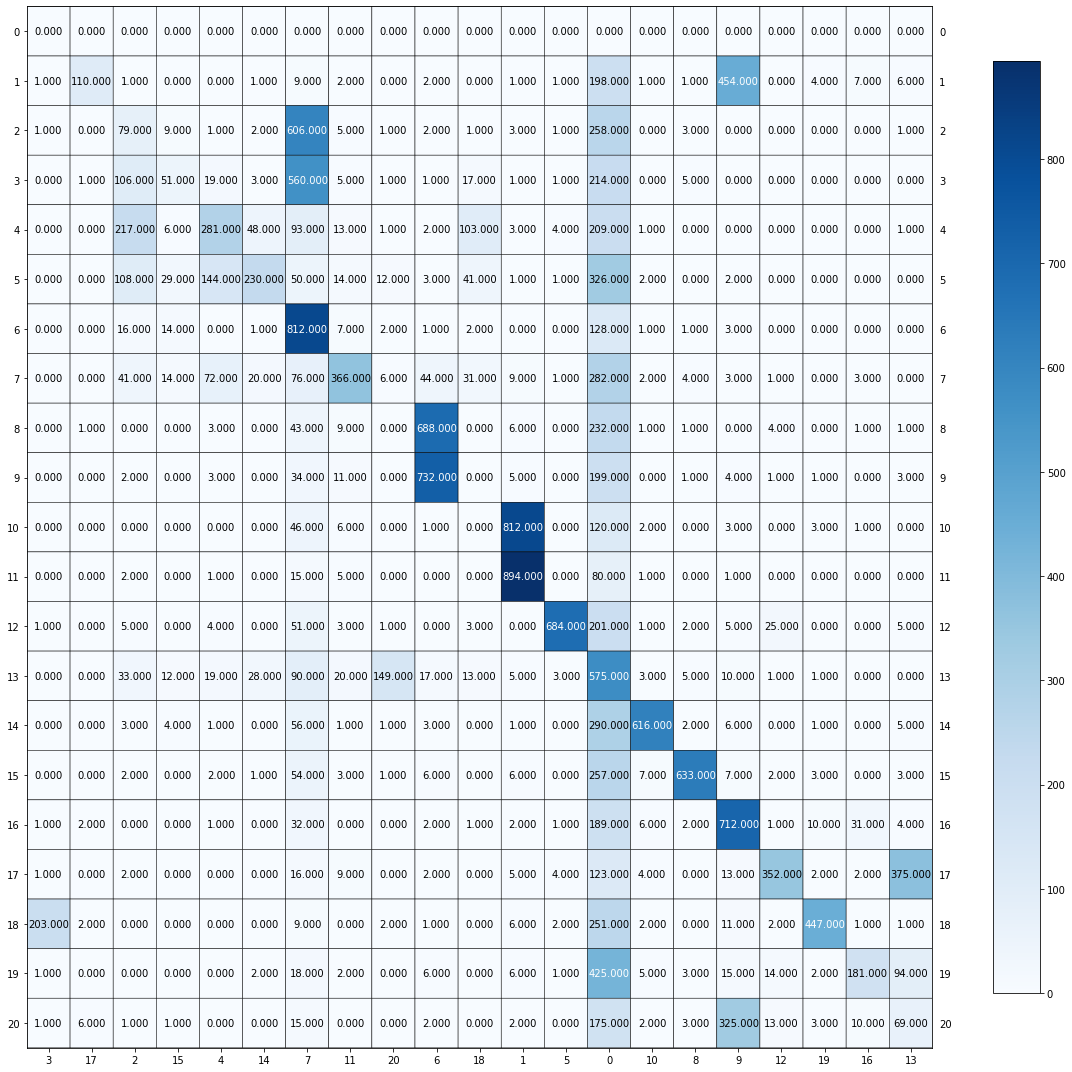

In [148]:
bestDBSCAN = DBSCAN(min_samples=100, eps=0.8, metric='manhattan')
bestDBSCAN.fit(UMAPDict[5])
bestDBLabels = mod.labels_

cmDB = confusion_matrix(labels, lab)
rows, cols = linear_sum_assignment(cmDB, maximize=True)
plot_mat(cmDB[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

### Contingency matrix for best HDBSCAN 

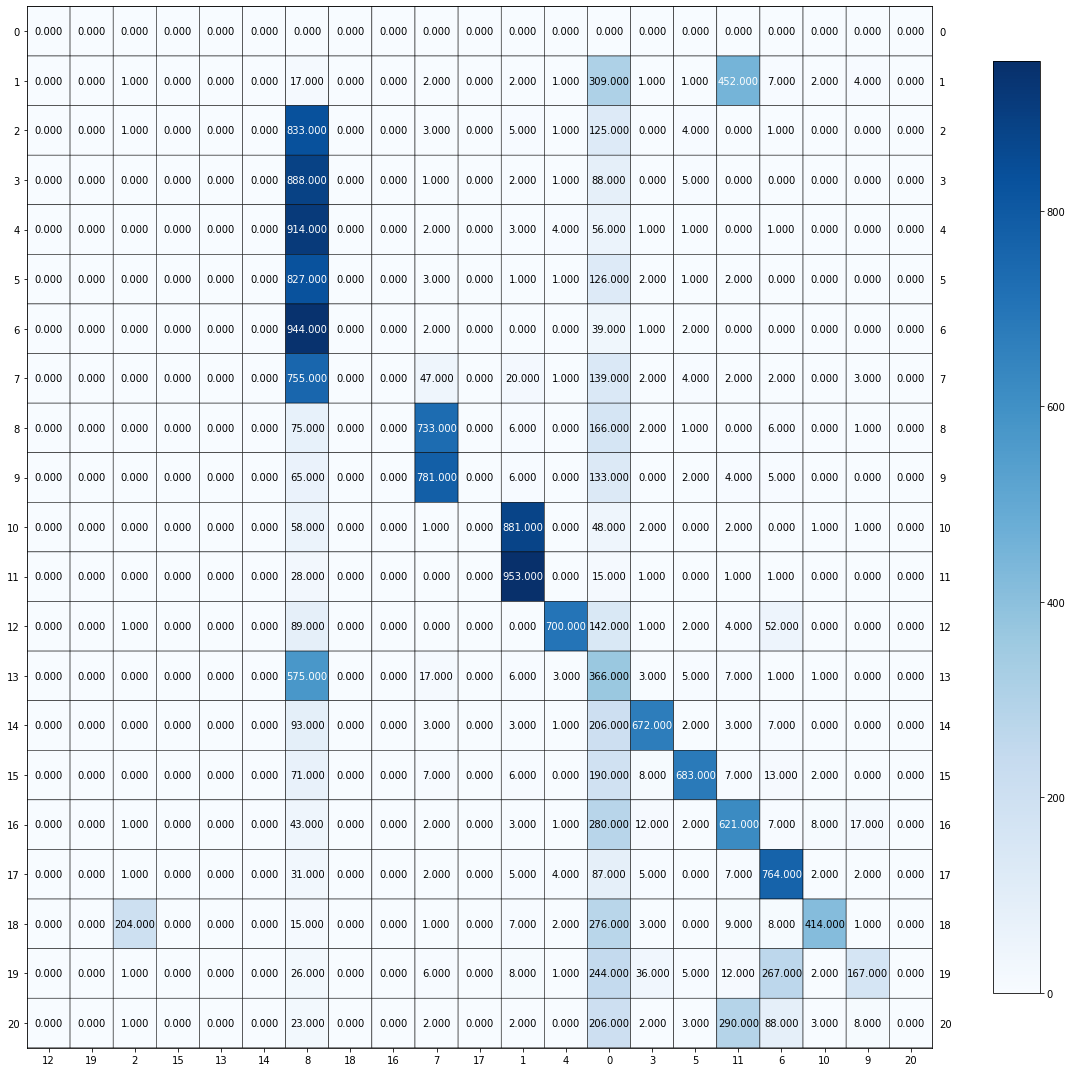

In [200]:
bestHDBSCAN = hdbscan.HDBSCAN(cluster_selection_epsilon=0.5, min_cluster_size=100, min_samples=100)
bestHDBSCAN.fit(UMAPDict[5])
bestHDBLabels = mod.labels_

cmHDB = confusion_matrix(labels, bestHDBLabels)
rows, cols = linear_sum_assignment(cmHDB, maximize=True)
plot_mat(cmHDB[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

#### Answer 16

The contingency matrices for both best DBSCAN and HDBSCAN with UMAP components are plotted above.

"-1" for the clustering labels means the data points which are considered as outliers/ noisy samples by the clustering alogrithm. They dont belong to any cluster.

There are 21 clusters for formed for both HDBSCAN and DBSCAN. Though some data points are considered as outliers by the algorithms and those re neglected.

Seeing the scores and contingency matrix, DBSCAN seems to perform better.

In [202]:
redDICT = {
    'SVD': SVDDict,
    'NMF': NMFDict,
    'UMAP': UMAPDict
}

### Question 17

In [203]:
# For K-means

bestKmeansScores = []
bestK = 10
bestRedK = 'None'
bestCompK = 5
reductions = ['None', 'SVD', 'NMF', 'UMAP']
components = [5, 20, 200]
bestARIK = 0
bestKMEANS = ""

clusters = [10, 20, 50]

for red in reductions:
    if red == 'None':
        for k in clusters:
            kmeans = KMeans(n_clusters=k, random_state=0, max_iter=3000, n_init=50).fit(fullFeatures)
            predictedLabels = kmeans.labels_
            scores = getScores(labels, predictedLabels)
            
            if scores['Adjusted Rand Index'] > bestARIK:
                bestARIK = scores['Adjusted Rand Index']
                bestRedK = 'None'
                bestKmeansScores = scores
                bestK = k
                bestKMEANS = kmeans
                bestCompK = 'All'
    else:
        for comp in components:
            xdata = redDICT[red][comp]
            for k in clusters:
                kmeans = KMeans(n_clusters=k, random_state=0, max_iter=3000, n_init=50).fit(xdata)
                predictedLabels = kmeans.labels_
                scores = getScores(labels, predictedLabels)

                if scores['Adjusted Rand Index'] > bestARIK:
                    bestARIK = scores['Adjusted Rand Index']
                    bestRedK = red
                    bestKmeansScores = scores
                    bestK = k
                    bestKMEANS = kmeans
                    bestCompK = comp

In [205]:
print("Best KMeans Scores: " , bestKmeansScores)
print("Best Number of Clusters: ", bestK)
print("Best Reduction Method: ", bestRedK)
print("Best Components for the reduction method: ", bestCompK)
print("Best Clusterer: ", bestKMEANS)

Best KMeans Scores:  {'Homogeneity': 0.5806805815300556, 'Completeness': 0.6115249272650983, 'V-measure': 0.5957037570532415, 'Adjusted Rand Index': 0.4569803695125659, 'Adjusted mutual information score': 0.5943523647530761}
Best Number of Clusters:  20
Best Reduction Method:  UMAP
Best Components for the reduction method:  200
Best Clusterer:  KMeans(max_iter=3000, n_clusters=20, n_init=50, random_state=0)


In [207]:
# For agglomerative clustering
#  Choosing WARD as it was performing best.

bestAggloScores = []
bestKAgglo = 20
bestRedAgglo = 'None'
bestCompAgglo = 5
reductions = ['None', 'SVD', 'NMF', 'UMAP']
components = [5, 20, 200]
bestARIAgglo = 0
bestAGGLO = ""

clusters = [20]

for red in reductions:
    if red == 'None':
        for k in clusters:
            AggClustering = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(fullFeatures.toarray())
            predictedLabels = AggClustering.labels_
            scores = getScores(labels, predictedLabels)
            
            if scores['Adjusted Rand Index'] > bestARIAgglo:
                bestARIAgglo = scores['Adjusted Rand Index']
                bestRedAgglo = 'None'
                bestAggloScores = scores
                bestKAgglo = k
                bestAGGLO = AggClustering
                bestCompAgglo = 'All'
    else:
        for comp in components:
            xdata = redDICT[red][comp]
            for k in clusters:
                AggClustering = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(xdata)
                predictedLabels = AggClustering.labels_
                scores = getScores(labels, predictedLabels)

                if scores['Adjusted Rand Index'] > bestARIAgglo:
                    bestARIAgglo = scores['Adjusted Rand Index']
                    bestRedAgglo = red
                    bestAggloScores = scores
                    bestKAgglo = k
                    bestAGGLO = AggClustering
                    bestCompAgglo = comp

In [208]:
print("Best Agglomerative Scores: " , bestAggloScores)
print("Best Number of Clusters: ", bestKAgglo)
print("Best Reduction Method: ", bestRedAgglo)
print("Best Components for the reduction method: ", bestCompAgglo)
print("Best Agglomerative Clusterer: ", bestAGGLO)

Best Agglomerative Scores:  {'Homogeneity': 0.5606966790260698, 'Completeness': 0.5999114955884185, 'V-measure': 0.5796415890276118, 'Adjusted Rand Index': 0.41951672531146084, 'Adjusted mutual information score': 0.5782252143043021}
Best Number of Clusters:  20
Best Reduction Method:  UMAP
Best Components for the reduction method:  200
Best Agglomerative Clusterer:  AgglomerativeClustering(n_clusters=20)


In [209]:
# For DBSCAN

bestDBScores = []
bestRedDB = 'SVD'
reductions = ['SVD', 'NMF', 'UMAP']
components = [5, 20, 200]
bestARIDB = 0
bestDB = ""
bestepsDB = 0.5
bestcompDB = 5

eps = [0.5, 5]

for red in reductions:
    for comp in components:
        xdata = redDICT[red][comp]
        for ep in eps:
            DBS = DBSCAN(eps=ep, metric='manhattan', min_samples=100)
            DBS.fit(xdata)
            scores = getScores(labels, DBS.labels_)

            if scores['Adjusted Rand Index'] > bestARIDB:
                bestARIDB = scores['Adjusted Rand Index']
                bestRedDB = red
                bestDBScores = scores
                bestepsDB = ep
                bestDB = DBS
                bestcompDB = comp

In [210]:
print("Best DBSCAN Scores: " , bestDBScores)
print("Best eps: ", bestepsDB)
print("Best Reduction Method: ", bestRedDB)
print("Best Components for the reduction method: ", bestcompDB)
print("Best DBSCAN: ", bestDB)

Best DBSCAN Scores:  {'Homogeneity': 0.33120205835686245, 'Completeness': 0.6945617362912734, 'V-measure': 0.44852485126850467, 'Adjusted Rand Index': 0.16235616472721429, 'Adjusted mutual information score': 0.447892746623063}
Best eps:  5
Best Reduction Method:  UMAP
Best Components for the reduction method:  200
Best DBSCAN:  DBSCAN(eps=5, metric='manhattan', min_samples=100)


In [211]:
# For HDBScan

bestHDBScores = []
bestRedHDB = 'SVD'
reductions = ['SVD', 'NMF', 'UMAP']
components = [5, 20, 200]
bestARIHDB = 0
bestHDB = ""
bestcompHDB = 5
bestminClustersHDB = 100

clusters = [100, 200]

for red in reductions:
    for comp in components:
        xdata = redDICT[red][comp]
        for k in clusters:
            HDB = hdbscan.HDBSCAN(cluster_selection_epsilon=0.5, min_cluster_size=k, min_samples=100)
            HDB.fit(xdata)
            scores = getScores(labels, HDB.labels_)

            if scores['Adjusted Rand Index'] > bestARIDB:
                bestARIHDB = scores['Adjusted Rand Index']
                bestRedHDB = red
                bestHDBScores = scores
                bestminClustersHDB = k
                bestHDB = HDB
                bestcompHDB = comp

In [212]:
print("Best HDBSCAN Scores: " , bestHDBScores)
print("Best min clusters: ", bestminClustersHDB)
print("Best Reduction Method: ", bestRedHDB)
print("Best Components for the reduction method: ", bestcompHDB)
print("Best DBSCAN: ", bestHDB)

Best HDBSCAN Scores:  {'Homogeneity': 0.4129198938992539, 'Completeness': 0.6174470134270562, 'V-measure': 0.49488420767373975, 'Adjusted Rand Index': 0.19576297047983665, 'Adjusted mutual information score': 0.4937516237378393}
Best min clusters:  200
Best Reduction Method:  UMAP
Best Components for the reduction method:  200
Best DBSCAN:  HDBSCAN(cluster_selection_epsilon=0.5, min_cluster_size=200, min_samples=100)


### Answer 17
The following grid was followed to determine the best combination to perform the clustering task.

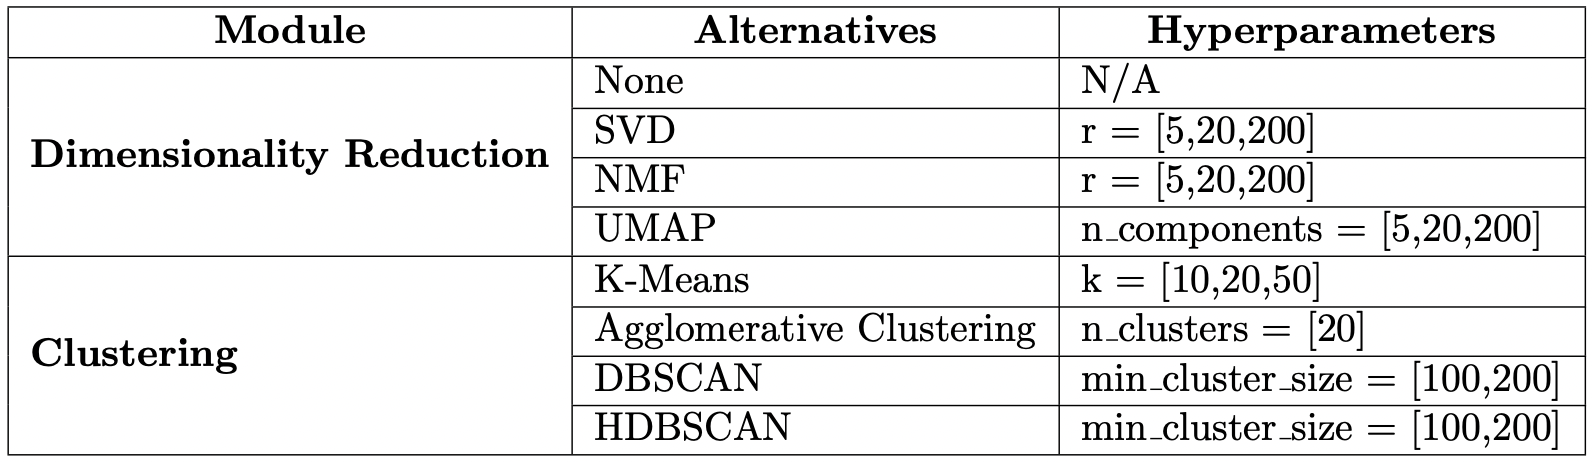

<b>Best KMeans Scores with hyperparameters:</b> 

'Homogeneity': 0.5806805815300556, <br>
'Completeness': 0.6115249272650983, <br>
'V-measure': 0.5957037570532415, <br>
'Adjusted Rand Index': 0.4569803695125659, <br>
'Adjusted mutual information score': 0.5943523647530761<br>
Best Number of Clusters:  20<br>
Best Reduction Method:  UMAP<br>
Best Components for the reduction method:  200<br>
Best Clusterer:  KMeans(max_iter=3000, n_clusters=20, n_init=50, random_state=0)


<b>Best Agglomerative Scores with hyperparameters:</b>  

'Homogeneity': 0.5606966790260698, <br>
'Completeness': 0.5999114955884185, <br>
'V-measure': 0.5796415890276118, <br>
'Adjusted Rand Index': 0.41951672531146084, <br>
'Adjusted mutual information score': 0.5782252143043021}<br>
Best Number of Clusters:  20<br>
Best Reduction Method:  UMAP<br>
Best Components for the reduction method:  200<br>
Best Agglomerative Clusterer:  AgglomerativeClustering(n_clusters=20)

<b>Best DBSCAN Scores with hyperparameters:</b>  
'Homogeneity': 0.33120205835686245, <br>
'Completeness': 0.6945617362912734, <br>
'V-measure': 0.44852485126850467, <br>
'Adjusted Rand Index': 0.16235616472721429, <br>
'Adjusted mutual information score': 0.447892746623063}<br>
Best eps:  5<br>
Best Reduction Method:  UMAP<br>
Best Components for the reduction method:  200<br>
Best DBSCAN:  DBSCAN(eps=5, metric='manhattan', min_samples=100)


<b>Best HDBSCAN Scores with hyperparameters:</b>  
'Homogeneity': 0.4129198938992539, <br>
'Completeness': 0.6174470134270562, <br>
'V-measure': 0.49488420767373975, <br>
'Adjusted Rand Index': 0.19576297047983665, <br>
'Adjusted mutual information score': 0.4937516237378393}<br>
Best min clusters:  200<br>
Best Reduction Method:  UMAP<br>
Best Components for the reduction method:  200<br>
Best DBSCAN:  HDBSCAN(cluster_selection_epsilon=0.5, min_cluster_size=200, min_samples=100)


From above results, the best combinations in decreasing order of average clustering measures:

1). KMeans + UMAP

2). Agglomerative clustering + UMAP

3). DBSCAN + UMAP

4). HDBSCAN + UMAP

The reason why UMAP is best compared to other dimensionality reduction techniques is because UMAP learns the global data structure and is less dependent on random initiators compared to NMF. Also UMAP with cosine similarity is performing much well because of the fact that sparse text document matrices are difficult to work with using SVD and NMF whereas cosine similarity measure is not much effected by it.

KMeans is performing well because, it uses the fact of prior number of clusters unlike DBSCAN and HDBSCAN which are highly sensitive to other parameters like eps and min_cluster_size. In Agglomerative clustering there is no such minimization happening in terms of intra cluster distances which is being performed extensively in KMeans optimization.

### Question 18

In [234]:
umap_mod = umap.UMAP(n_components=50)
UMAPFeat = umap_mod.fit_transform(fullFeatures)

svdmod = getSVD(50, fullFeatures)
svdFeat = svdmod.transform(fullFeatures)

In [248]:
nmfmod = getNMF(50, fullFeatures)
nmfFeat = nmfmod.transform(fullFeatures)

In [243]:
crossed = np.multiply(UMAPFeat, svdFeat)

In [244]:
clusterer = KMeans(n_clusters=20, random_state=0, max_iter=3000, n_init=50).fit(crossed)
clustLabs = clusterer.labels_

In [245]:
getScores(labels, clustLabs)

{'Homogeneity': 0.27836989706305004,
 'Completeness': 0.3335059715132977,
 'V-measure': 0.30345378116014127,
 'Adjusted Rand Index': 0.08149556694266143,
 'Adjusted mutual information score': 0.3009870693322971}

In [259]:
# Keeping header and footers of data

data = datasets.fetch_20newsgroups(subset='all')

In [260]:
fullData = data.data
labelNames = np.array(data.target_names)
fullDataLabels = np.array(data.target)
stringLabels = np.array([labelNames[label] for label in fullDataLabels])

In [263]:
pipe = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(fullData)

newsData3df = pipe.transform(fullData)

In [264]:
pipe = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=5)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(fullData)

newsData5df = pipe.transform(fullData)

In [311]:
umap_mod = umap.UMAP(n_components=100, random_state=42)
UMAPFeat3 = umap_mod.fit_transform(newsData3df)

svdmod = getSVD(100, newsData3df)
svdFeat3 = svdmod.transform(newsData3df)

umap_mod = umap.UMAP(n_components=100, random_state=42)
UMAPFeat5 = umap_mod.fit_transform(newsData5df)

svdmod = getSVD(100, newsData5df)
svdFeat5 = svdmod.transform(newsData5df)

In [329]:
clusterer = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(UMAPFeat3)
clustLabs = clusterer.labels_
getScores(labels, clustLabs)

{'Homogeneity': 0.5377529918200834,
 'Completeness': 0.5696767485293908,
 'V-measure': 0.5532547388430132,
 'Adjusted Rand Index': 0.43050889147870935,
 'Adjusted mutual information score': 0.5517557788353247}

In [330]:
clusterer = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(svdFeat3)
clustLabs = clusterer.labels_
getScores(labels, clustLabs)

{'Homogeneity': 0.3744111494089925,
 'Completeness': 0.46459306903108544,
 'V-measure': 0.41465542403778416,
 'Adjusted Rand Index': 0.13739295602486884,
 'Adjusted mutual information score': 0.41252473959983915}

In [331]:
clusterer = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(UMAPFeat5)
clustLabs = clusterer.labels_
getScores(labels, clustLabs)

{'Homogeneity': 0.5267248371135923,
 'Completeness': 0.553470030490929,
 'V-measure': 0.5397663336506847,
 'Adjusted Rand Index': 0.41868703780435773,
 'Adjusted mutual information score': 0.5382405122437159}

In [332]:
clusterer = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(svdFeat5)
clustLabs = clusterer.labels_
getScores(labels, clustLabs)

{'Homogeneity': 0.3275364431703451,
 'Completeness': 0.41027035386490357,
 'V-measure': 0.3642647180349287,
 'Adjusted Rand Index': 0.1351860325744043,
 'Adjusted mutual information score': 0.3619497993048606}

### Answer 18

Two approaches are tried:

- Using a combination of SVD and UMAP. The 50 dimensionally reduced features were taken from both and multiplied together element wise. The idea was may be the feature representation with this maps the data points far away in the combined reduced space of SVD and UMAP representation.

The above approach failed big time. 
The scores of which are given below.

'Homogeneity': 0.27836989706305004, <br>
'Completeness': 0.3335059715132977,<br>
'V-measure': 0.30345378116014127,<br>
'Adjusted Rand Index': 0.08149556694266143,<br>
'Adjusted mutual information score': 0.3009870693322971


- Making the changes in the data itself.

1). Using the full data from 20 news group without removing the header and footers.

Two variations were tried for this and best combination from previous results i.e UMAP with K-means and SVD with K-Means were tried.

n_components for both SVD and UMAP = 50<br>
n_clusters = 20.<br>
n_init = 50<br>
max_iter = 5000<br>

- Using min_df = 3 with TF-IDF representation.

a). UMAP + KMeans: <br>
    'Homogeneity': 0.5377529918200834, <br>
     'Completeness': 0.5696767485293908,<br>
     'V-measure': 0.5532547388430132,<br>
     'Adjusted Rand Index': 0.43050889147870935,<br>
     'Adjusted mutual information score': 0.5517557788353247
     

b). SVD + Kmeans:<br>
    'Homogeneity': 0.3744111494089925,<br>
     'Completeness': 0.46459306903108544,<br>
     'V-measure': 0.41465542403778416,<br>
     'Adjusted Rand Index': 0.13739295602486884,<br>
     'Adjusted mutual information score': 0.41252473959983915

- Using min_df = 5 with TF-IDF representation.

a).UMAP + Kmeans: <br>
'Homogeneity': 0.5267248371135923,<br>
 'Completeness': 0.553470030490929,<br>
 'V-measure': 0.5397663336506847,<br>
 'Adjusted Rand Index': 0.41868703780435773,<br>
 'Adjusted mutual information score': 0.5382405122437159
 
b). SVD + Kmeans:

'Homogeneity': 0.3275364431703451,<br>
 'Completeness': 0.41027035386490357,<br>
 'V-measure': 0.3642647180349287,<br>
 'Adjusted Rand Index': 0.1351860325744043,<br>
 'Adjusted mutual information score': 0.3619497993048606
 
 The Adjusted Rand index of this approach were almost equivalent to the results without header and footer but on average the results of all the metrics were improved a little bit.